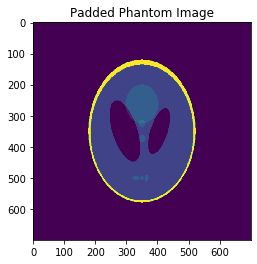

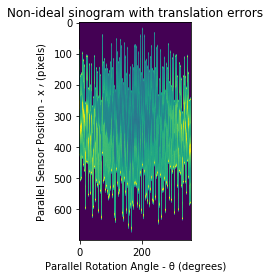

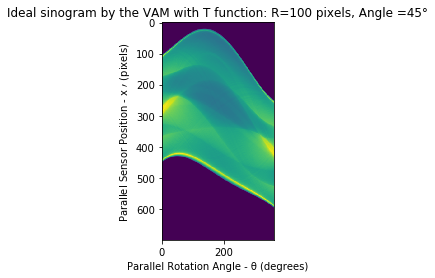

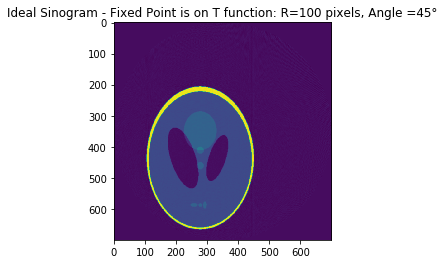

In [59]:
# Copyright 2017 Kyungtaek Jun
# Licensed under the MIT License
# https://www.mit.edu/~amini/LICENSE.md

####################################################################
### Virtual Alignment Method for Rigid Sample with Phantom Image ###
### Scientific Reports, 2017                                     ###
####################################################################

# module import part
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"
import numpy as np
import matplotlib.pyplot as plt
#from phantominator import shepp_logan
import random, math
import cv2

from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, radon, iradon, iradon_sart


# the position of fixed point in the polar coordinate system
##############################################################
fp_r = 100           # Radius from the center of Reconstrucion
fp_phi = 45          # Angle (degree)
##############################################################

# initial set up
max_angle = 180           # rotating angle
projections = 360         # number of projection images
dtheta = max_angle/projections
theta = np.arange(0, max_angle, dtheta)

# make phantom image by 500*500 pixels
pnx = 500                # size of phantom
P = shepp_logan_phantom()
P = rescale(P, scale=1.25)
# plt.title('Modified Shepp-Logan')

#%%% padding 100 pixels around the image
Pad = 100
inx = pnx + 2*Pad
iny = inx
#IS = zeros(inx)   #;     % Initial set up for Image Sample
IS = np.zeros((inx,iny))  # To make a matrix with dimension inx*inx

for j in range(Pad ,iny-Pad-1):
    for i in range(Pad ,inx-Pad-1):
        temp_val = P[i-Pad, j-Pad]

        if temp_val < 0:   # % remove negative values for making videos
            IS[i,j] = 0
        else:
            IS[i,j] = temp_val
plt.figure()           
plt.title('Padded Phantom Image')
plt.imshow(IS)

# random errors
ER = Pad            # range of errors
vt_er = np.zeros(projections)                 # vertial translation errors
for k in range(projections):
    vt_er[k] = random.randint(-ER,ER)
      
pt_er = np.zeros(projections)                 # parallel translation erros
for k in range(projections):
    pt_er[k] = random.randint(-ER,ER)

# set up non ideal sinogram
sino_nonideal = np.zeros((700,0))

for k in range( projections):
    M = np.float32( [ [1, 0, int( vt_er[k] ) ], [ 0, 1, int( pt_er[k] ) ] ] )  # translation matrix    
    new_IS = cv2.warpAffine(IS, M, (cols, rows))
    
    nsino_clm = radon(new_IS, theta=[theta[k]], circle=True)
    sino_nonideal = np.hstack( [sino_nonideal , nsino_clm] ) 

plt.figure()
plt.title('Non-ideal sinogram with translation errors')
plt.xlabel('Parallel Rotation Angle - \u03B8 (degrees)')
plt.ylabel('Parallel Sensor Position - x $\prime$ (pixels)')
plt.imshow(sino_nonideal)

#########%%% ideal sinogram by applying virtual alignment method
[snx, sny] = sino_nonideal.shape
sino_ideal = np.zeros((snx,sny))

deg_to_rad = np.pi/180
Virtural_RA = round(snx/2)   

for j in range(projections):
    pjtd_CA_x = 0
    total_MAC = 0
    for i in range(snx):
        pjtd_CA_x = pjtd_CA_x + (i)*sino_nonideal[i,j]
        total_MAC = total_MAC + sino_nonideal[i,j]

    pjtd_CA_x = pjtd_CA_x/total_MAC 
    T = fp_r*np.cos(((j+1)*dtheta-fp_phi)*deg_to_rad)       #% T function with Radius and Angle
    pjtd_CA_x = pjtd_CA_x + T

    ceil_pjtd_CA_x = np.ceil(pjtd_CA_x)
    floor_pjtd_CA_x = np.floor(pjtd_CA_x)
    right_ratio = pjtd_CA_x - floor_pjtd_CA_x
    left_ratio = ceil_pjtd_CA_x - pjtd_CA_x

    if left_ratio == 0:
        left_ratio = 1

    move = int(Virtural_RA - floor_pjtd_CA_x)
    for i in range(1,snx-2):
        if i+move <= 1 or i+move >= snx:
            continue
        else:
            sino_ideal[ i+move,j] = sino_nonideal[i,j]*left_ratio + sino_nonideal[i+1,j]*right_ratio

            
plt.figure()
plt.title('Ideal sinogram by the VAM with T function: R='+str(fp_r)+' pixels, Angle ='+str(fp_phi)+'\u00B0')
plt.xlabel('Parallel Rotation Angle - \u03B8 (degrees)')
plt.ylabel('Parallel Sensor Position - x $\prime$ (pixels)')
plt.imshow(sino_ideal)
Recon = iradon(sino_ideal, theta=theta, circle=True)

plt.figure()
plt.title('Ideal Sinogram - Fixed Point is on T function: R='+str(fp_r)+' pixels, Angle ='+str(fp_phi)+'\u00B0')
plt.imshow(Recon)